In [ ]:
import os
import json
import random
import numpy as np

import random
from scipy.stats import chi2
import matplotlib.pyplot as plt
from numpy import sqrt

In [116]:
class IGMN:
    def __init__(self, input_dim, beta):
        self.input_dim = input_dim
        self.beta = beta
        self.components = []

    def squared_mahalanobis_distance(self, x, mu, cov):
        sigma_inv = np.linalg.inv(cov)
        diff = x - mu
        d_sq = diff.T @ sigma_inv @ diff
        return d_sq.item()
    
    def pdf(self, x, mu, cov):
        D = self.input_dim
        d_sq = self.squared_mahalanobis_distance(x, mu, cov)
        norm_constant = 1 / ((2 * np.pi) ** (D/2) * np.linalg.det(cov) ** (1/2))
        return norm_constant * np.exp(-0.5 * d_sq)

    def create_new_component(self, x, components):
        mu = x
        acc = 1
        age = 1

        # pi => mixing coefficient 
        # also called: p(j) or p(z_j = 1) 
        # -> probability of selecting component j
        if len(components) > 0:
            p = 1 / (sum([comp['acc'] for comp in components]) + 1)
        else:
            p = 1

        sigma_ini = 0.01
        sigma = sigma_ini * np.eye(len(x))

        if not np.all(np.linalg.eigvals(sigma) > 0):
            print("Problem: Sigma is not positive definite - x: ", x, " sigma: ", sigma)
            raise ValueError("Sigma is not positive definite")

        # print("Created new component with mu = ", mu, " sigma = ", sigma, " p = ", p, " acc = ", acc, " age = ", age)

        return {"mu": mu, "sigma": sigma, "p": p, "acc": acc, "age": age}
    

    def filter(self, age_min=5.0, acc_min=3.0):
        """A component j is removed whenever u_j > u_min and sp_j < sp_min, where u_min and sp_min are user-defined thresholds.

        In that case, also, p(k) must be adjusted for all k in K (with k != j).
        In other words, each component is given some tim eu_min to show its importance to the model in the form of an accumulation of its posterior probability sp_j
        """
        for j, component_j in enumerate(self.components):
            if component_j['age'] > age_min and component_j['acc'] < acc_min:
                print("Removing component ", j)
                self.components.pop(j)
                self.update_priors()

    
    def update(self, x, i, rank="full"):
        

        if not self.components:
            print("No components yet, creating new one")
            new_component = self.create_new_component(x, self.components)
            self.components.append(new_component)
            return
        
        D = self.input_dim
        beta = self.beta
        chi_sq_threshold = chi2.ppf(1-beta, D)

        updated = False

        self.filter()

        for j, component_j in enumerate(self.components):

            d_sq = self.squared_mahalanobis_distance(x, 
                                                     component_j['mu'], 
                                                     component_j['sigma']) # equation 1)
            
            # check if d_sq is negative and throw error otherwise
            if d_sq < 0:
                raise ValueError(f"Negative squared Mahalanobis distance: {d_sq} based on x = {x}, mu = {component_j['mu']}, sigma = {component_j['sigma']}")

            if d_sq < chi_sq_threshold:
                #print(f" Iteration: {i} with comp_{j} - d_sq = {round(d_sq, 2)} <  {round(chi_sq_threshold, 2)}")
                
                denom = 0
                for comp in self.components:
                    p_x_k = self.pdf(x, comp['mu'], comp['sigma'])
                    denom += p_x_k * comp['p']

                p_x_j = self.pdf(x, component_j['mu'], component_j['sigma']) # equation 2
                p_j_x = (p_x_j * component_j['p']) / denom # equation 3

                component_j['age'] = component_j['age'] + 1 # equation 4
                component_j['acc'] = component_j['acc'] + p_j_x # equation 5

                e_j = x - component_j['mu'] # equation 6
                omega_j = p_j_x / component_j['acc'] # equation 7
                
                delta_mu_j = omega_j * e_j # equation 8

                component_j['mu'] = component_j['mu'] + delta_mu_j # equation 9

                e_j2 = x - component_j['mu'] # equation 10

                
                copy = component_j["sigma"].copy()

                # print("Old: \n", component_j["sigma"])
                # print("Term 1\n", (1 - omega_j) * copy)
                # print("Term 2", omega_j * (e_j2 @ e_j2.T))
                # print("Term 3", delta_mu_j @ delta_mu_j.T)


                # print("---------")
                # print("Origin of e_j -> x: ", x, " mu_j: ", component_j['mu'], " e_j: ", e_j)
                # print("Origin of term 3 -> omega_j: ", omega_j, " e_j: ", e_j, " delta_mu_j: ", delta_mu_j)
                # print("---------")

                # clip delta_mu_j to avoid making the covariance matrix non positive definite
                delta_mu_j = np.clip(delta_mu_j, -0.01, 0.01)

                component_j["sigma"] = \
                    (1 - omega_j) * copy \
                    + omega_j * (e_j2 @ e_j2.T) \
                    - delta_mu_j @ delta_mu_j.T # equation 11
                
                # do not use full rank covariance matrix, only keep variances
                if rank == "diag":
                    component_j["sigma"] = np.diag(np.diag(component_j["sigma"]))
                
                if not np.all(np.linalg.eigvals(component_j["sigma"]) > 0):
                    #print("Problem2: Sigma is not positive definite - x: ", x, " sigma: ", component_j["sigma"])
                    #print("Copy: ", copy)
                    #print("New: ", component_j["sigma"])
                    raise ValueError("Sigma is not positive definite")
                
                component_j['p'] = component_j['acc'] / sum([comp['acc'] for comp in self.components]) # equation 12

                updated = True
        
        if not updated:
            # print("Creating new component for x = ", x)
            new_component = self.create_new_component(x, self.components)
            self.components.append(new_component)
        
        self.update_priors()

    def update_priors(self):
        "-> lateral inhibition"
        total_acc = sum([comp['acc'] for comp in self.components])
        for comp in self.components:
            comp['p'] = comp['acc'] / total_acc

In [107]:
def gen_data(k=3, dim=2, points_per_cluster=200, lim=[-10, 10]):
    '''
    Generates data from a random mixture of Gaussians in a given range.

    - k: Number of Gaussian clusters
    - dim: Dimension of generated points
    - points_per_cluster: Number of points to be generated for each cluster
    - lim: Range of mean values

    '''
    x = []
    mean = np.random.rand(k, dim)*(lim[1]-lim[0]) + lim[0]
    for i in range(k):
        cov = np.random.rand(dim, dim+10)
        cov = np.matmul(cov, cov.T)
        _x = np.random.multivariate_normal(mean[i], cov, points_per_cluster)
        x += list(_x)
    x = np.array(x)
    return x # generated points (points_per_cluster*k, dim)

def plot_data(x):
    dim = x.shape[1]
    fig = plt.figure()
    ax = fig.gca()

    if (dim == 1):
        #ax.hist(x, bins=50, alpha=0.7)
        ax.scatter(x, np.zeros_like(x), s=10, alpha=0.4)
        # put y lim between 0 and 1
        ax.set_ylim(-0.2, 1)
    if(dim == 2):
        ax.scatter(x[:,0], x[:,1], s=3, alpha=0.4)
        ax.autoscale(enable=True)


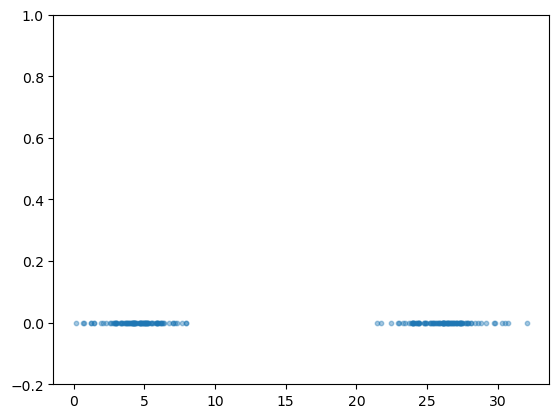

In [111]:
X = gen_data(k=2, dim=1, points_per_cluster=100, lim=[-50, 50])

plot_data(X)

In [109]:
# def is_pos_def(x):
#     return np.all(np.linalg.eigvals(x) > 0)

# def is_symmetric(x):
#     return np.all(x-x.T==0)

# # check if the covariance matrix is positive definite
# cov = np.array([[-4.78534862e-05, -5.04785349e-03],
#                 [-5.04785349e-03, -4.78534862e-05]])



# print(is_pos_def(cov), is_symmetric(cov))


# print(np.linalg.det(cov))

In [126]:
igmn = IGMN(input_dim=1, beta=0.001)
idx = 0

In [127]:
looped = 0

In [128]:
# create a function that allows me to run 10 more samples out X


for i in range(500):


    x = X[idx]
    
    if (idx % 100) == 0:
        print("Iteration: ", (len(X) * looped) + idx, x)

    # for j, comp in enumerate(igmn.components):
    #     if not np.all(np.linalg.eigvals(comp['sigma']) > 0):
    #         print("Covariance matrix is not positive definite!")
    #         print(comp['sigma'], j, idx, x)
    #         raise ValueError("Covariance matrix is not positive definite!")
    igmn.update(x, idx)
    idx += 1

    # loop again over indices if we reached the end
    if idx == len(X):
        idx = 0
        looped += 1

Iteration:  0 [25.66840608]
No components yet, creating new one
Iteration:  100 [5.16599413]
Removing component  31
Iteration:  200 [25.66840608]
Iteration:  300 [5.16599413]
Iteration:  400 [25.66840608]


In [131]:

print("Number of components: ", len(igmn.components))
# find component with highest p
max_p = 0
max_comp = None
for comp in igmn.components:
    if comp['p'] > max_p:
        max_p = comp['p']
        max_comp = comp
print(max_comp)

#for component in igmn.components:
    
    # if component["age"] > 0:
    #     print("age: ", component['age'], " acc: ", component['acc'], " p: ", component['p'])

Number of components:  34
{'mu': array([5.01914112]), 'sigma': array([[0.06710857]]), 'p': 0.11017010675649602, 'acc': 54.305954903902574, 'age': 64}


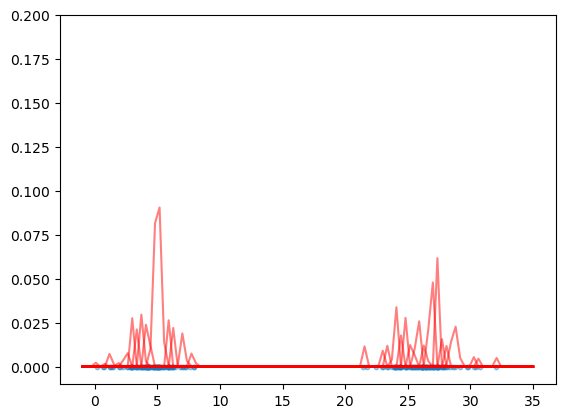

In [147]:
# draw 2d density function for the component with highest p overlayed with the data

def plot_data(x, igmn):
    dim = x.shape[1]
    fig = plt.figure()
    ax = fig.gca()

    if (dim == 1):
        #ax.hist(x, bins=50, alpha=0.7)
        ax.scatter(x, np.zeros_like(x), s=10, alpha=0.4)
        # put y lim between 0 and 1
        ax.set_ylim(-0.2, 1)
    if(dim == 2):
        ax.scatter(x[:,0], x[:,1], s=3, alpha=0.4)
        ax.autoscale(enable=True)

    # each component is part of gaussian mixture model, draw the density function
    # weigth each component by its mixing coefficient p 

    for component in igmn.components:
        mu = component['mu']
        sigma = component['sigma']
        p = component['p']

        if dim == 1:
            x = np.linspace(-1, 35, 100)
            y = p * np.exp(-0.5 * (x - mu)**2 / sigma)
            ax.plot(x, y[0], color='red', alpha=0.5)

    # set max y lim between -0.01 and 0.2
    ax.set_ylim(-0.01, 0.2)


    
plot_data(X, igmn)



In [ ]:
# create 

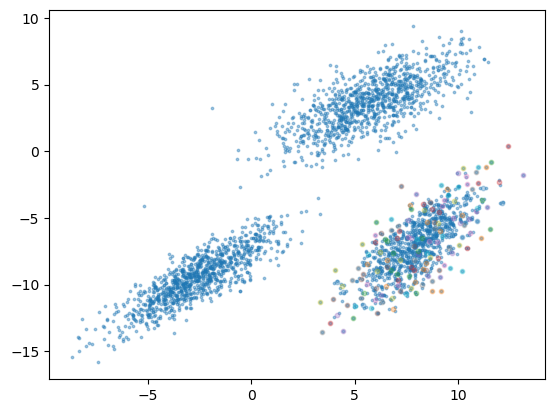

In [41]:
# sort components by age
sorted(igmn.components, key=lambda x: x['age'], reverse=True)[0:10]

# draw the first 3 components on the plot of the generated data
fig = plt.figure()
ax = fig.gca()
ax.scatter(X[:,0], X[:,1], s=3, alpha=0.4)
ax.autoscale(enable=True)

for comp in igmn.components:
    ax.scatter(comp['mu'][0], comp['mu'][1], s=10, alpha=0.3)


In [ ]:
x = np.array([ -7.57918632, -12.55769486])
mu = np.array([-7.10540817, -8.75339249])

cov = np.eye(2)
cov = np.array([[-0.00050521, -0.0055289 ],
                 [-0.0055289,  -0.00050521]])

print(sqrt(igmn.squared_mahalanobis_distance(x, mu, cov)))

from scipy.spatial import distance
print(distance.mahalanobis(x, mu, np.linalg.inv(cov)))

In [ ]:
for component in igmn.components:
    print("Component mean:", component['mu'])
    print("Component covariance matrix:", component['sigma'])
    print("Component prior probability:", component['p'])
